**In this notebook, we demonstrate the application of Random Forest, Naive Bayes and Neural Network to perform classification task with San Francisco Crime Dataset**

The steps of the classification task:
1. Import Libraries
1. Preliminary Analysis
1. Data Preparation
1. Feature Selection
1. Dataset Splitting
1. Random Forest Modelling
1. Neural Network Modelling
1. Naive Bayes Modelling

In [ ]:
# 1. Import Libraries
# Visualization Libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#Preprocessing Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

# ML Libraries
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

# Evaluation Metrics
from yellowbrick.classifier import ClassificationReport
from sklearn import metrics

In [32]:
# Read dataset and display first 5 row
df = pd.read_csv('../input/train.csv', error_bad_lines=False) 
df.head(5)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [33]:
# 2. Preliminary Analysis
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
Dates         878049 non-null object
Category      878049 non-null object
Descript      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Resolution    878049 non-null object
Address       878049 non-null object
X             878049 non-null float64
Y             878049 non-null float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


In [4]:
# 3. Data Preparation
# Remove irrelevant/not meaningfull attributes
df = df.drop(['Descript'], axis=1)
df = df.drop(['Resolution'], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 878049 entries, 0 to 878048
Data columns (total 7 columns):
Dates         878049 non-null object
Category      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Address       878049 non-null object
X             878049 non-null float64
Y             878049 non-null float64
dtypes: float64(2), object(5)
memory usage: 53.6+ MB


In [37]:
# Splitting the Date to Day, Month, Year, Hour, Minute, Second
df['date2'] = pd.to_datetime(df['Dates'])
df['Year'] = df['date2'].dt.year
df['Month'] = df['date2'].dt.month
df['Day'] = df['date2'].dt.day
df['Hour'] = df['date2'].dt.hour
df['Minute'] = df['date2'].dt.minute
df['Second'] = df['date2'].dt.second 
df = df.drop(['Dates'], axis=1) 
df = df.drop(['date2'], axis=1)
df.head(5)

,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Year,Month,Day,Hour,Minute,Second
0,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23,53,0
1,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23,53,0
2,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,5,13,23,33,0
3,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,5,13,23,30,0
4,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015,5,13,23,30,0


In [38]:
# Convert Categorical Attributes to Numerical
df['PdDistrict'] = pd.factorize(df["PdDistrict"])[0]
df['Address'] = pd.factorize(df["Address"])[0]
df['DayOfWeek'] = pd.factorize(df["DayOfWeek"])[0]
df['Year'] = pd.factorize(df["Year"])[0]
df['Month'] = pd.factorize(df["Month"])[0]
df['Day'] = pd.factorize(df["Day"])[0]
df['Hour'] = pd.factorize(df["Hour"])[0]
df['Minute'] = pd.factorize(df["Minute"])[0]
df['Second'] = pd.factorize(df["Second"])[0] 
df.head(5)

,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Year,Month,Day,Hour,Minute,Second
0,WARRANTS,WARRANT ARREST,0,0,"ARREST, BOOKED",0,-122.425892,37.774599,0,0,0,0,0,0
1,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,0,0,"ARREST, BOOKED",0,-122.425892,37.774599,0,0,0,0,0,0
2,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,0,0,"ARREST, BOOKED",1,-122.424363,37.800414,0,0,0,0,1,0
3,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,0,0,NONE,2,-122.426995,37.800873,0,0,0,0,2,0
4,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,0,1,NONE,3,-122.438738,37.771541,0,0,0,0,2,0


In [39]:
# Display targer class
Target = 'Category'
print('Target: ', Target)

Target:  Category


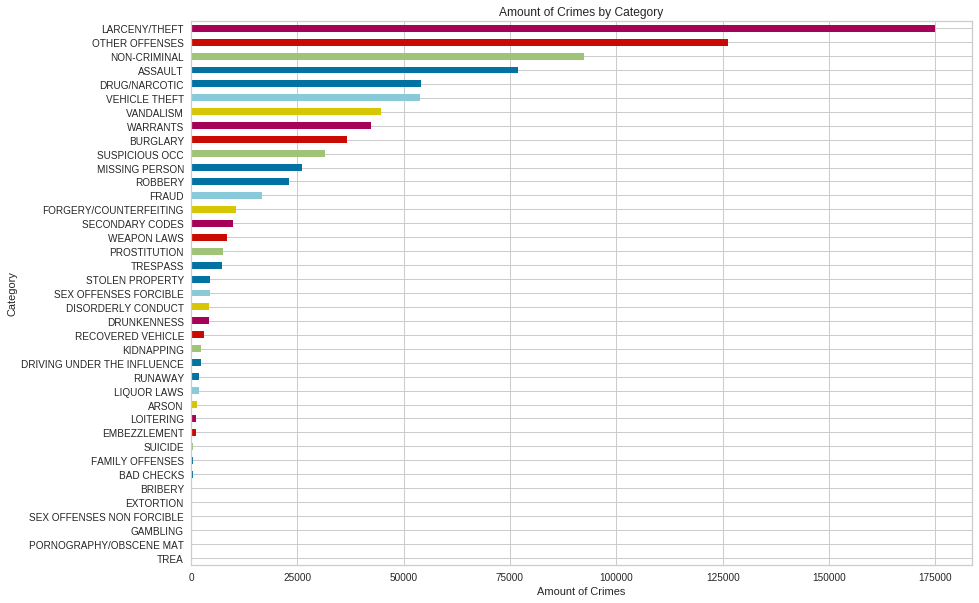

In [40]:
# Plot Bar Chart visualize Crime Types
plt.figure(figsize=(14,10))
plt.title('Amount of Crimes by Category')
plt.ylabel('Crime Category')
plt.xlabel('Amount of Crimes')

df.groupby([df['Category']]).size().sort_values(ascending=True).plot(kind='barh')

plt.show()

In [10]:
# Display all unique classes
Classes = df['Category'].unique()
Classes

array(['WARRANTS', 'OTHER OFFENSES', 'LARCENY/THEFT', 'VEHICLE THEFT',
       'VANDALISM', 'NON-CRIMINAL', 'ROBBERY', 'ASSAULT', 'WEAPON LAWS',
       'BURGLARY', 'SUSPICIOUS OCC', 'DRUNKENNESS',
       'FORGERY/COUNTERFEITING', 'DRUG/NARCOTIC', 'STOLEN PROPERTY',
       'SECONDARY CODES', 'TRESPASS', 'MISSING PERSON', 'FRAUD',
       'KIDNAPPING', 'RUNAWAY', 'DRIVING UNDER THE INFLUENCE',
       'SEX OFFENSES FORCIBLE', 'PROSTITUTION', 'DISORDERLY CONDUCT',
       'ARSON', 'FAMILY OFFENSES', 'LIQUOR LAWS', 'BRIBERY',
       'EMBEZZLEMENT', 'SUICIDE', 'LOITERING',
       'SEX OFFENSES NON FORCIBLE', 'EXTORTION', 'GAMBLING', 'BAD CHECKS',
       'TREA', 'RECOVERED VEHICLE', 'PORNOGRAPHY/OBSCENE MAT'],
      dtype=object)

In [41]:
#Encode target labels into categorical variables:
df['Category'] = pd.factorize(df["Category"])[0] 
df['Category'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38])

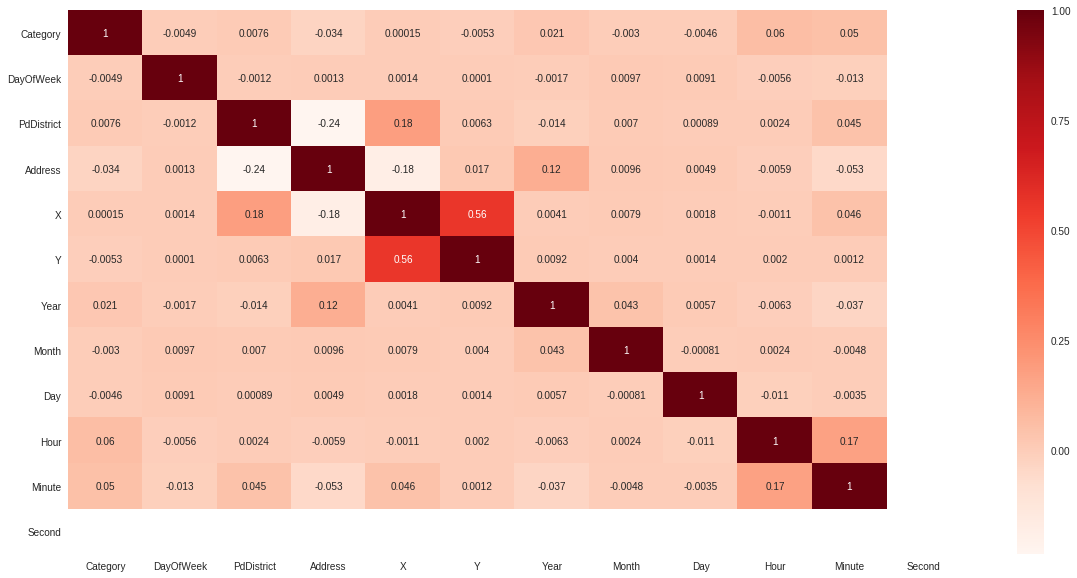

In [42]:
# 4. Feature Selection using Filter Method 
# Split Dataframe to target class and features
X_fs = df.drop(['Category'], axis=1)
Y_fs = df['Category']

#Using Pearson Correlation
plt.figure(figsize=(20,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [48]:
#Correlation with output variable
cor_target = abs(cor['Category'])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.02]
relevant_features

Category    1.000000
Address     0.033553
Year        0.021299
Hour        0.060419
Minute      0.050273
Name: Category, dtype: float64

In [49]:
# At Current Point, the attributes is select manually based on Feature Selection Part. 
Features = ["Address","Year","Hour", "Minute" ]
print('Full Features: ', Features) 

Full Features:  ['Address', 'Year', 'Hour', 'Minute']


In [50]:
# 5. Split dataset to Training Set & Test Set
x, y = train_test_split(df, 
                        test_size = 0.2, 
                        train_size = 0.8, 
                        random_state= 3)

x1 = x[Features]    #Features to train
x2 = x[Target]      #Target Class to train
y1 = y[Features]    #Features to test
y2 = y[Target]      #Target Class to test

print('Feature Set Used    : ', Features)
print('Target Class        : ', Target)
print('Training Set Size   : ', x.shape)
print('Test Set Size       : ', y.shape)

Feature Set Used    :  ['Address', 'Year', 'Hour', 'Minute']
Target Class        :  Category
Training Set Size   :  (702439, 14)
Test Set Size       :  (175610, 14)


In [51]:
# 6. Random Forest
# Create Model with configuration
rf_model = RandomForestClassifier(n_estimators=70, # Number of trees
                                  min_samples_split = 30,
                                  bootstrap = True, 
                                  max_depth = 50, 
                                  min_samples_leaf = 25)

# Model Training
rf_model.fit(X=x1,
             y=x2)

# Prediction
result = rf_model.predict(y[Features])

In [52]:
# Model Evaluation
ac_sc = accuracy_score(y2, result)
rc_sc = recall_score(y2, result, average="weighted")
pr_sc = precision_score(y2, result, average="weighted")
f1_sc = f1_score(y2, result, average='micro')
confusion_m = confusion_matrix(y2, result)

print("========== Random Forest Results ==========")
print("Accuracy    : ", ac_sc)
print("Recall      : ", rc_sc)
print("Precision   : ", pr_sc)
print("F1 Score    : ", f1_sc)
print("Confusion Matrix: ")
print(confusion_m)

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


========== Random Forest Results ==========
Accuracy    :  0.26573088092933206
Recall      :  0.26573088092933206
Precision   :  0.22310505269627948
F1 Score    :  0.26573088092933206
Confusion Matrix: 
[[   72  4659  2116 ...     0     0     0]
 [  100 13251  8016 ...     0     0     0]
 [   38  5006 25706 ...     0     0     0]
 ...
 [    0     1     0 ...     0     0     0]
 [    1   415   111 ...     0     0     0]
 [    0     3     2 ...     0     0     0]]


In [56]:
# 7. Neural Network
# Create Model with configuration 
nn_model = MLPClassifier(solver='adam', 
                         alpha=1e-5,
                         hidden_layer_sizes=(40,), 
                         random_state=1,
                         max_iter=1000                         
                        )

# Model Training
nn_model.fit(X=x1,
             y=x2)

# Prediction
result = nn_model.predict(y[Features]) 

In [57]:
# Model Evaluation
ac_sc = accuracy_score(y2, result)
rc_sc = recall_score(y2, result, average="weighted")
pr_sc = precision_score(y2, result, average="weighted")
f1_sc = f1_score(y2, result, average='micro')
confusion_m = confusion_matrix(y2, result)

print("========== Neural Network Results ==========")
print("Accuracy    : ", ac_sc)
print("Recall      : ", rc_sc)
print("Precision   : ", pr_sc)
print("F1 Score    : ", f1_sc)
print("Confusion Matrix: ")
print(confusion_m)

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


========== Neural Network Results ==========
Accuracy    :  0.23534536757587837
Recall      :  0.23534536757587837
Precision   :  0.1493945231673971
F1 Score    :  0.23534536757587837
Confusion Matrix: 
[[   14  5538  2136 ...     0     0     0]
 [   23 15338  8121 ...     0     0     0]
 [   12  9364 24068 ...     0     0     0]
 ...
 [    0     1     0 ...     0     0     0]
 [    0   446   118 ...     0     0     0]
 [    0     3     3 ...     0     0     0]]


In [54]:
# 8. Naive Bayes
# Create Model with configuration 
nb_model = GaussianNB() 

# Model Training
nb_model.fit(X=x1, 
             y=x2)

# Prediction
result = nb_model.predict(y[Features])

In [55]:
# Model Evaluation
ac_sc = accuracy_score(y2, result)
rc_sc = recall_score(y2, result, average="weighted")
pr_sc = precision_score(y2, result, average="weighted")
f1_sc = f1_score(y2, result, average='micro')
confusion_m = confusion_matrix(y2, result)

print("========== Naive Bayes Results ==========")
print("Accuracy    : ", ac_sc)
print("Recall      : ", rc_sc)
print("Precision   : ", pr_sc)
print("F1 Score    : ", f1_sc)
print("Confusion Matrix: ")
print(confusion_m)

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


========== Naive Bayes Results ==========
Accuracy    :  0.22469677125448437
Recall      :  0.22469677125448437
Precision   :  0.15352202590157144
F1 Score    :  0.22469677125448437
Confusion Matrix: 
[[    0  3457  4572 ...     0     0     0]
 [    0  8811 14734 ...     0     0     0]
 [    0  3945 28290 ...     0     0     0]
 ...
 [    0     1     0 ...     0     0     0]
 [    0   298   247 ...     0     0     0]
 [    0     1     5 ...     0     0     0]]
